In [1]:
import cv2
import numpy as np
import caffe
from caffe.proto import caffe_pb2
import lmdb
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import axes3d
import glob
%matplotlib notebook


In [2]:
import sys
import os
import cPickle as pickle
import os
sys.path.append('libs/')
from lmdb_utils import *
from numpy.random import seed
from numpy.random import shuffle

In [3]:
#Fijar modo de caffe CPU
#caffe.set_mode_cpu()

#Fijar modo de caffe GPU
caffe.set_device(0)
caffe.set_mode_gpu()

In [4]:
def load_CIFAR_batch(filename):
  """ load single batch of cifar """
  with open(filename, 'rb') as f:
    datadict = pickle.load(f)
    X = datadict['data']
    Y = datadict['labels']
    X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
    Y = np.array(Y)
    return X, Y

In [5]:
def load_CIFAR10(ROOT):
  """ load all of cifar """
  xs = []
  ys = []
  for b in range(1,6):
    f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
    X, Y = load_CIFAR_batch(f)
    xs.append(X)
    ys.append(Y)    
  Xtr = np.concatenate(xs)
  Ytr = np.concatenate(ys)
  del X, Y
  Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
  return Xtr, Ytr, Xte, Yte

# 1.- Preparar bases de datos

Descargar de fuente: https://www.cs.toronto.edu/~kriz/cifar.html

---------Entrenamiento---------
Dimensiones de la entrada: (50000, 32, 32, 3)
Dimensiones de las etiquetas: (50000,)
---------Validacion---------
Dimensiones de la entrada: (10000, 32, 32, 3)
Dimensiones de la etiqueta: (10000,)


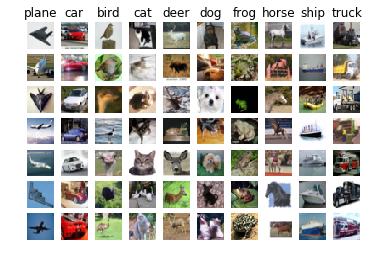

In [6]:
#Load the raw CIFAR-10 data.
cifar10_dir = 'dataset/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

#Check size of the training and test data.
print('---------Entrenamiento---------')
print('Dimensiones de la entrada: ' + str(X_train.shape))
print('Dimensiones de las etiquetas: ' + str(y_train.shape))
print('---------Validacion---------')
print('Dimensiones de la entrada: ' + str(X_test.shape))
print('Dimensiones de la etiqueta: ' + str(y_test.shape))

#Imprimir ejemplos
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [7]:
#Redimensionar arreglos
X_train = np.transpose(X_train,(0,3,1,2))
X_test = np.transpose(X_test,(0,3,1,2))

#Generar bases de datos
create_lmdb_dataset('dataset/CNN/train_lmdb', X_train, y_train)
create_lmdb_dataset('dataset/CNN/test_lmdb', X_test, y_test)

122880000000
24576000000


Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)


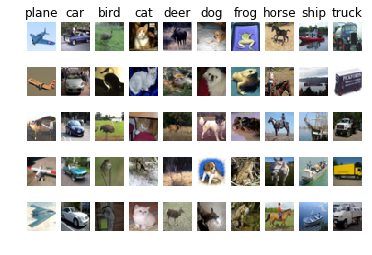

In [8]:
#Extraer datos de fuente lmdb
X_train, y_train = load_lmdb_dataset('dataset/images_train_lmdb', 50000, 3, 32, 32)

#Redimensionar a dimensiones de imagen
X_train = np.transpose(X_train,(0,2,3,1))

#Verificar dimensiones de la base de datos
print('Training data shape: ' + str(X_train.shape))
print('Training labels shape: ' +  str(y_train.shape))

#Print some examples
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 5
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

# 3.- Definir modelo

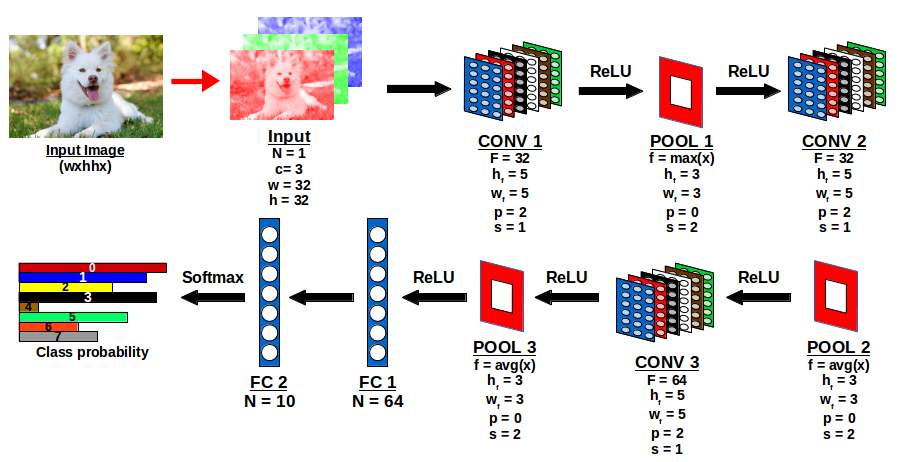

In [9]:
from IPython.display import Image
Image('model/CNN/network2.png')

In [10]:
#Print neural network structure and optimization parameters
print 'Neural network structure'
!cat model/CNN/CNN_train.prototxt

print 'Optimizacion parameters'
!cat model/CNN/solver.prototxt

Neural network structure
name: "CIFAR10_quick"
layer {
  name: "cifar"
  type: "Data"
  top: "data"
  top: "label"
  include {
    phase: TRAIN
  }
  transform_param {
    mean_file: "/home/edgar/Caffe_course/example2/dataset/train_mean.binaryproto"
  }
  data_param {
    source: "/home/edgar/Caffe_course/example2/dataset/train_lmdb"
    batch_size: 100
    backend: LMDB
  }
}
layer {
  name: "cifar"
  type: "Data"
  top: "data"
  top: "label"
  include {
    phase: TEST
  }
  data_param {
    source: "/home/edgar/Caffe_course/example2/dataset/test_lmdb"
    batch_size: 100
    backend: LMDB
  }
}
layer {
  name: "conv1"
  type: "Convolution"
  bottom: "data"
  top: "conv1"
  param {
    lr_mult: 1
  }
  param {
    lr_mult: 2
  }
  convolution_param {
    num_output: 32
    pad: 2
    kernel_size: 5
    stride: 1
    weight_filler {
      type: "gaussian"
      std: 0.0001
    }
    bias_filler {
      type: "constant"
    }
  }
}
layer {
  name: "pool1"
  type: "Pooling"
  bottom: "c

## 3.1 .- Entrenar modelo

In [4]:
#Ubicación del modelo
#Model path
net_root = 'model/CNN/'

#Model and solver prototxt
modelo = net_root + 'FCNN_train.prototxt'
solver = net_root + 'solver.prototxt'

#Init solver
caffe_solver = caffe.get_solver(solver)

#Train network
caffe_solver.solve()

# 3.2.- Ṕrobar modelo

In [4]:
#Direccion del modelo
model = 'model/CNN/CNN_deploy.prototxt'
weights = 'model/CNN/CNN_w.caffemodel'

#Construir modelo
net = caffe.Net(model, weights, caffe.TEST)

In [5]:
#Imprimir flujo de informacion
for layer_name, blob in net.blobs.iteritems():
    print layer_name + '\t' + str(blob.data.shape)

data	(1, 3, 32, 32)
conv1	(1, 32, 32, 32)
pool1	(1, 32, 16, 16)
conv2	(1, 32, 16, 16)
pool2	(1, 32, 8, 8)
conv3	(1, 64, 8, 8)
pool3	(1, 64, 4, 4)
ip1	(1, 64)
ip2	(1, 10)
prob	(1, 10)


In [6]:
#Cargar datos de prueba
path = glob.glob("dataset/CNN/testing_images/*.jpg")
print path

#Sort path
path.sort()

#Init Arrays
out_labels = np.zeros([13,10])

j = 0
#Obtener prediccion para cada imagen
for i in path:
    
    #Leer imagen
    im = cv2.imread(i)
    
    #Redimensionar a tamaño de la red
    im_r = cv2.resize(im,(32,32))
    
    #Reordenar entrada a blob
    im_r = np.transpose(im_r,(2,0,1))
    
    #Ingresar entrada en la red
    net.blobs['data'].data[...] = im_r
    
    #Ejecutar red
    out = net.forward()
    
    #Obtener salida y guardar informacion
    p = out['prob']
    out_labels[j] = p
    j = j + 1

['dataset/CNN/testing_images/image2.jpg', 'dataset/CNN/testing_images/image12.jpg', 'dataset/CNN/testing_images/image1.jpg', 'dataset/CNN/testing_images/image4.jpg', 'dataset/CNN/testing_images/image5.jpg', 'dataset/CNN/testing_images/image8.jpg', 'dataset/CNN/testing_images/image6.jpg', 'dataset/CNN/testing_images/image11.jpg', 'dataset/CNN/testing_images/image13.jpg', 'dataset/CNN/testing_images/image3.jpg', 'dataset/CNN/testing_images/image7.jpg', 'dataset/CNN/testing_images/image10.jpg', 'dataset/CNN/testing_images/image9.jpg']


/home/edgarmg/.local/lib/python2.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  # Remove the CWD from sys.path while we load stuff.


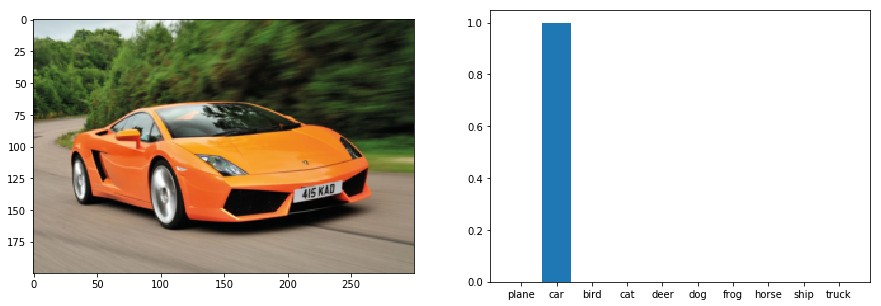

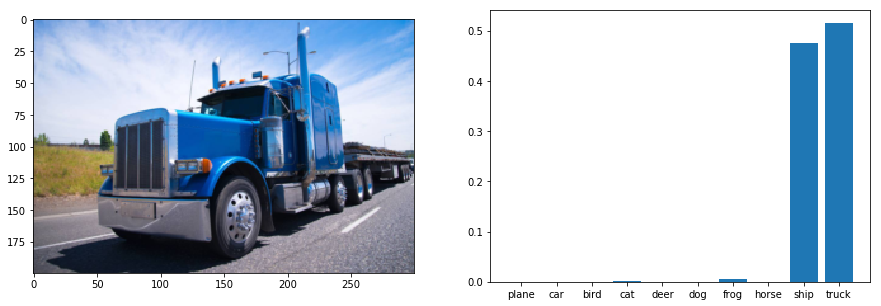

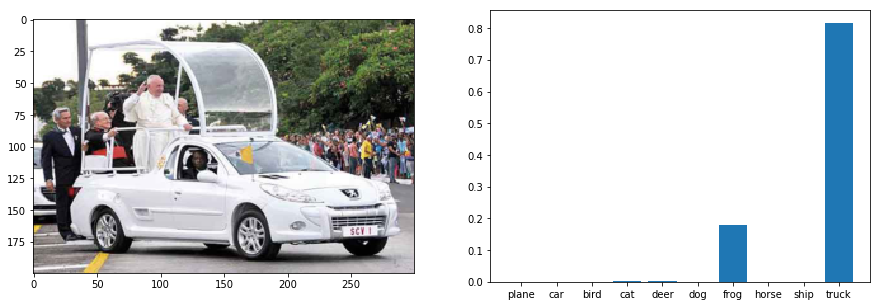

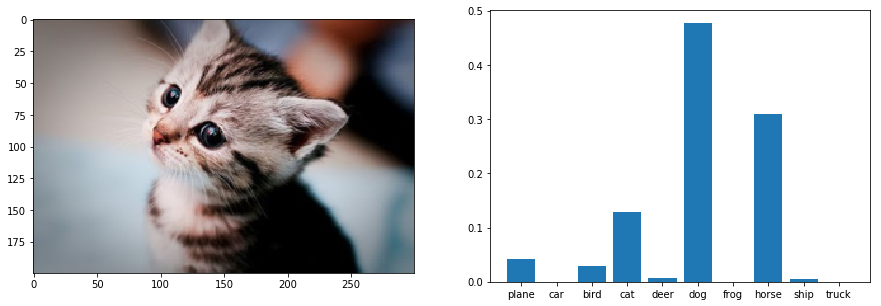

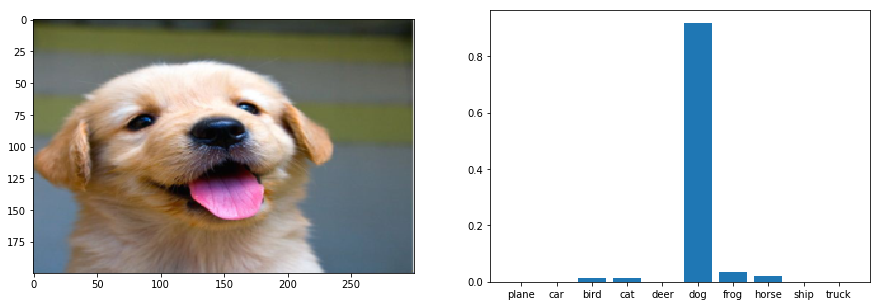

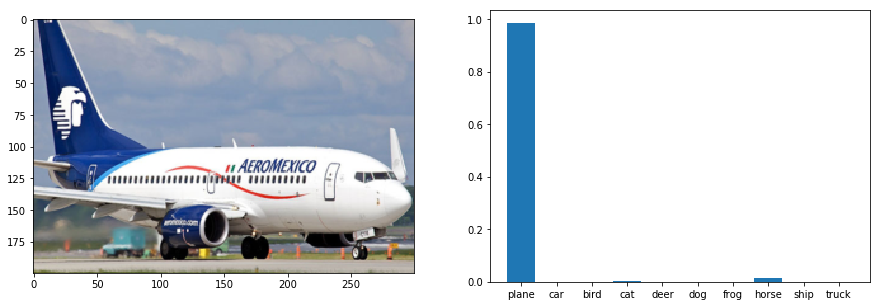

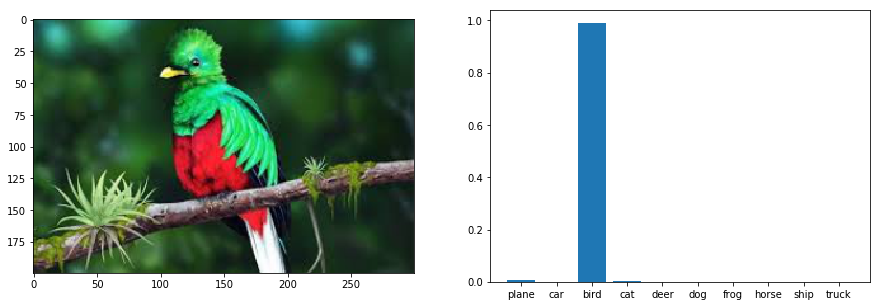

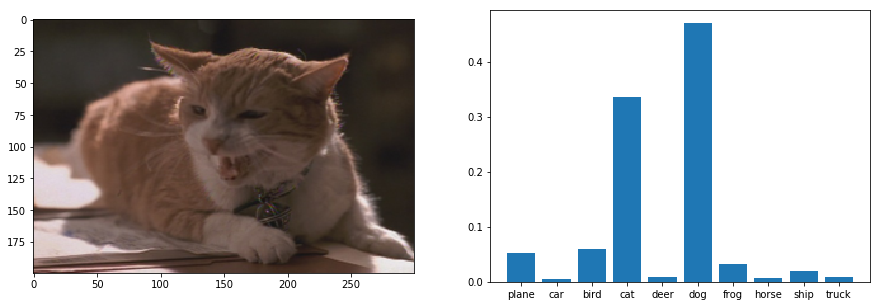

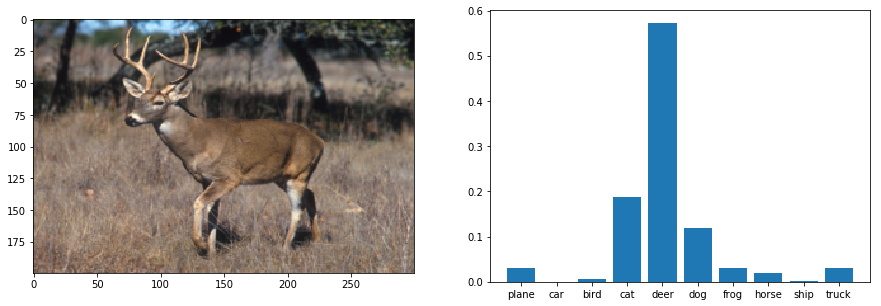

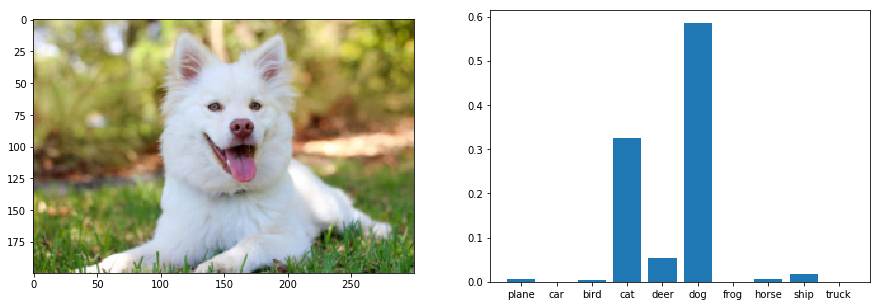

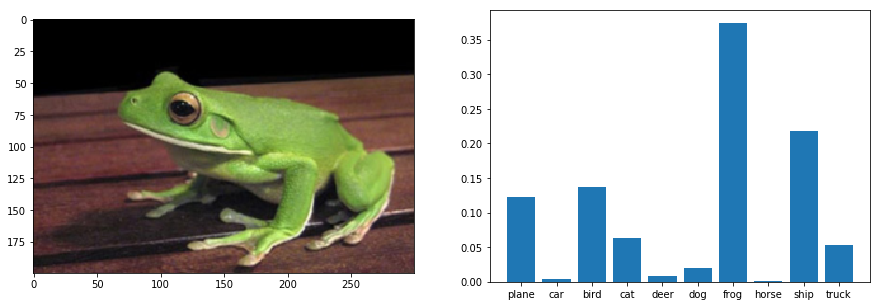

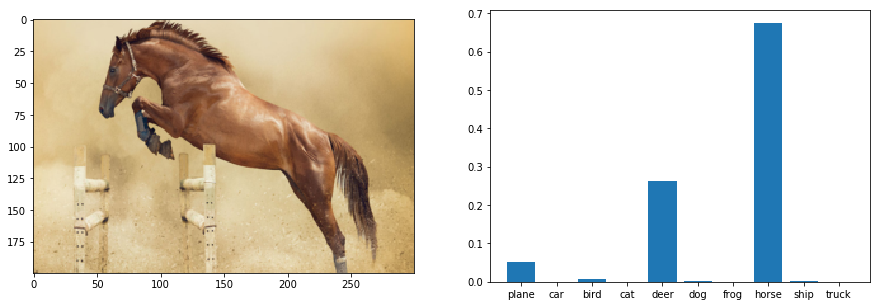

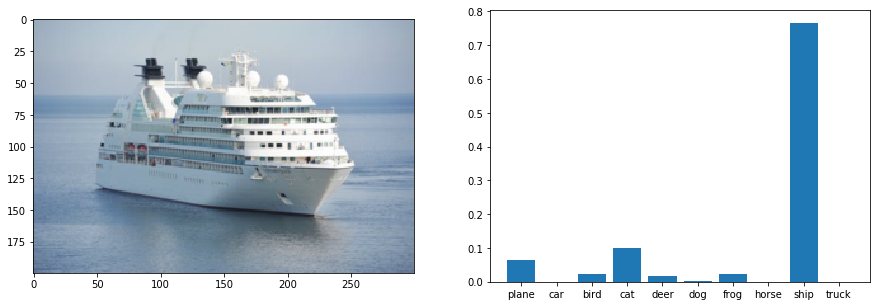

In [9]:
from PIL import Image
from scipy.misc import imresize
j = 0
for i in path:
    
    #Leer imagen
    im = np.array(Image.open(i),dtype = int)
    
    #Redimensionar imagen a tamaño de impresion
    im_r = imresize(im,(200,300))
    
    #Parametros de grafico
    plt.rcParams['figure.figsize'] = (15, 5) 
    
    #Imprimir imagen original
    fig = plt.figure(j)
    fig.add_subplot(121)
    plt.imshow(im_r.astype('uint8'))

    #Imprimir predicciones de la red
    ax = fig.add_subplot(122)
    nombres = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    datos = [out_labels[j,0],out_labels[j,1],out_labels[j,2],out_labels[j,3],out_labels[j,4],out_labels[j,5],out_labels[j,6],out_labels[j,7],out_labels[j,8],out_labels[j,9]]
    xx = range(len(datos))
    ax.bar(xx, datos, width=0.8, align='center')
    ax.set_xticks(xx)
    ax.set_xticklabels(nombres)
    j = j + 1

    plt.show()